In [43]:
from typing import List, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
%matplotlib inline

In [44]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [45]:
train.head(3)

ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   

     var_7  ...  var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.6266  ...   4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   
1  16.5338  ...   7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   
2  14.6155  ...   2.9057   9.7905   1.6704   1.6858  21.6042   3.1417   

   var_196  var_197  var_198  var_199  
0   7.8784   8.5635  12.7803  -1.0914  
1   8.1267   8.7889  18.3560   1.9518  
2  -6.5213   8.2675  14.7222   0.3965  

[3 rows x 202 columns]

In [46]:
test.head(3)

ID_code    var_0    var_1    var_2   var_3    var_4   var_5   var_6  \
0  test_0  11.0656   7.7798  12.9536  9.4292  11.4327 -2.3805  5.8493   
1  test_1   8.5304   1.2543  11.3047  5.1858   9.1974 -4.0117  6.0196   
2  test_2   5.4827 -10.3581  10.1407  7.0479  10.2628  9.8052  4.8950   

     var_7   var_8  ...  var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.2675  2.1337  ...  -2.1556  11.8495  -1.4300   2.4508  13.7112   2.4669   
1  18.6316 -4.4131  ...  10.6165   8.8349   0.9403  10.1282  15.5765   0.4773   
2  20.2537  1.5233  ...  -0.7484  10.9935   1.9803   2.1800  12.9813   2.1281   

   var_196  var_197  var_198  var_199  
0   4.3654  10.7200  15.4722  -8.7197  
1  -1.4852   9.8714  19.1293 -20.9760  
2  -7.1086   7.0618  19.8956 -23.1794  

[3 rows x 201 columns]

**Задание 1:** Сделать базовый анализ данных: вывести размерность датасетов, посчитать базовые статистики, выполнить анализ пропусков, сделать выводы

In [47]:
print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))
train.describe()

train.shape = 200000 rows, 202 cols
test.shape = 200000 rows, 201 cols


target          var_0          var_1          var_2  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.100490      10.679914      -1.627622      10.715192   
std         0.300653       3.040051       4.050044       2.640894   
min         0.000000       0.408400     -15.043400       2.117100   
25%         0.000000       8.453850      -4.740025       8.722475   
50%         0.000000      10.524750      -1.608050      10.580000   
75%         0.000000      12.758200       1.358625      12.516700   
max         1.000000      20.315000      10.376800      19.353000   

               var_3          var_4          var_5          var_6  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        6.796529      11.078333      -5.065317       5.408949   
std         2.043319       1.623150       7.863267       0.866607   
min        -0.040200       5.074800     -32.562600       2.347300   
25%         5.254075       9.883175     -11.200350       4.767700   
50%         6.825000      11.108250      -4.833150       5.385100   
75%         8.324100      12.261125       0.924800       6.003000   
max        13.188300      16.671400      17.251600       8.447700   

               var_7          var_8  ...        var_190        var_191  \
count  200000.000000  200000.000000  ...  200000.000000  200000.000000   
mean       16.545850       0.284162  ...       3.234440       7.438408   
std         3.418076       3.332634  ...       4.559922       3.023272   
min         5.349700     -10.505500  ...     -14.093300      -2.691700   
25%        13.943800      -2.317800  ...      -0.058825       5.157400   
50%        16.456800       0.393700  ...       3.203600       7.347750   
75%        19.102900       2.937900  ...       6.406200       9.512525   
max        27.691800      10.151300  ...      18.440900      16.716500   

             var_192        var_193        var_194        var_195  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        1.927839       3.331774      17.993784      -0.142088   
std         1.478423       3.992030       3.135162       1.429372   
min        -3.814500     -11.783400       8.694400      -5.261000   
25%         0.889775       0.584600      15.629800      -1.170700   
50%         1.901300       3.396350      17.957950      -0.172700   
75%         2.949500       6.205800      20.396525       0.829600   
max         8.402400      18.281800      27.928800       4.272900   

             var_196        var_197        var_198        var_199  
count  200000.000000  200000.000000  200000.000000  200000.000000  
mean        2.303335       8.908158      15.870720      -3.326537  
std         5.454369       0.921625       3.010945      10.438015  
min       -14.209600       5.960600       6.299300     -38.852800  
25%        -1.946925       8.252800      13.829700     -11.208475  
50%         2.408900       8.888200      15.934050      -2.819550  
75%         6.556725       9.593300      18.064725       4.836800  
max        18.321500      12.000400      26.079100      28.500700  

[8 rows x 201 columns]

In [48]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [49]:
train.isnull().sum()

ID_code    0
target     0
var_0      0
var_1      0
var_2      0
var_3      0
var_4      0
var_5      0
var_6      0
var_7      0
var_8      0
var_9      0
var_10     0
var_11     0
var_12     0
var_13     0
var_14     0
var_15     0
var_16     0
var_17     0
var_18     0
var_19     0
var_20     0
var_21     0
var_22     0
var_23     0
var_24     0
var_25     0
var_26     0
var_27     0
var_28     0
var_29     0
var_30     0
var_31     0
var_32     0
var_33     0
var_34     0
var_35     0
var_36     0
var_37     0
var_38     0
var_39     0
var_40     0
var_41     0
var_42     0
var_43     0
var_44     0
var_45     0
var_46     0
var_47     0
var_48     0
var_49     0
var_50     0
var_51     0
var_52     0
var_53     0
var_54     0
var_55     0
var_56     0
var_57     0
var_58     0
var_59     0
var_60     0
var_61     0
var_62     0
var_63     0
var_64     0
var_65     0
var_66     0
var_67     0
var_68     0
var_69     0
var_70     0
var_71     0
var_72     0
var_73     0
var_74     0

In [50]:
numerical_features = train.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features.shape[1]}")

numerical_features.columns

count of numeric_features 201


Index(['target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6',
       'var_7', 'var_8',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=201)

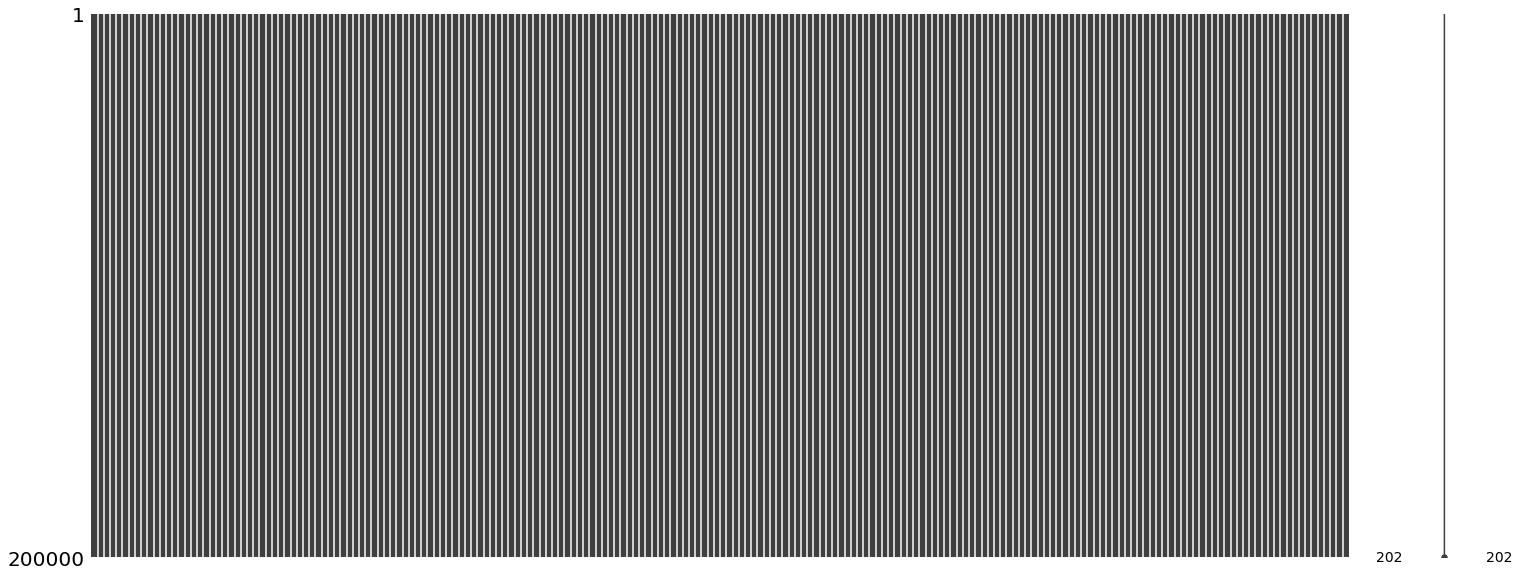

In [51]:
msno.matrix(train)

In [52]:
discrete_feature = [
    feature for feature in numerical_features
    if len(train[feature].unique())<25 and feature not in ["target"]
]

print(f"Discrete Variables Count: {len(discrete_feature)}")

Discrete Variables Count: 0


In [53]:
continuous_feature = [
    feature for feature in numerical_features
    if feature not in discrete_feature + ["target"]
]
print(f"Continuous Feature Count {len(continuous_feature)}")

Continuous Feature Count 200


В датафрейме 200тыс наблюдений, 201 признак и целевая переменная. Все признаки, кроме, ID_code - числовые (непрерывные). Пропусков нет.

**Задание 2:** Сделать базовый анализ целевой переменной, сделать выводы;

In [54]:
target = train['target']
target.value_counts()

0    179902
1     20098
Name: target, dtype: int64

In [55]:
target.value_counts(normalize=True)

0    0.89951
1    0.10049
Name: target, dtype: float64

Доля позитивного класса составляет 10% (20098 наблюдений). Наблюдается дисбалланс классов, но работать с такими данными можно.

**Задание 3:** Построить распределение признаков в зависимости от значения целевой переменной и распределение признаков для обучающей и тестовой выборки (если машина не позволяет построить распределение для всех признаков, то выполнить задание для признаков var_0, var_1, var_2, var_5, var_9, var_10, var_13, var_20, var_26, var_40, var_55, var_80, var_106, var_109, var_139, var_175, var_184, var_196), сделать выводы;

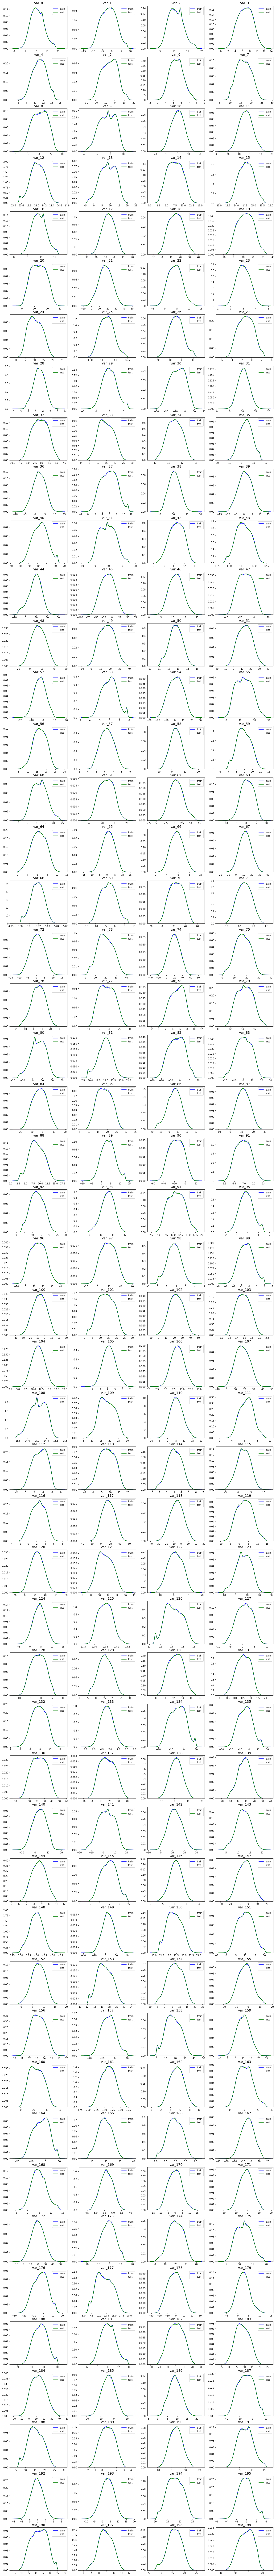

In [56]:
fig, axes = plt.subplots(50, 4, figsize=(20, 200))

for num, feature in enumerate(continuous_feature):
    try:
        train_data, test_data = train[feature].copy(), test[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
        sns.kdeplot(test_data, ax=axes[num//4, num%4], color="green", label="test")
    except RuntimeError:
        pass
    except KeyError:
        train_data = train[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
    axes[num//4, num%4].set_title(feature, fontsize=14)

In [57]:
target = train['target']

fig, axes = plt.subplots(50, 4, figsize=(50, 550))

for num, feature in enumerate(continuous_feature):
    data = train[feature].copy()
    sns.boxplot(y=feature, x=target, data=train, palette="viridis", ax=axes[num//4, num%4]) 
    axes[num//4, num%4].tick_params(axis="x", rotation=90)

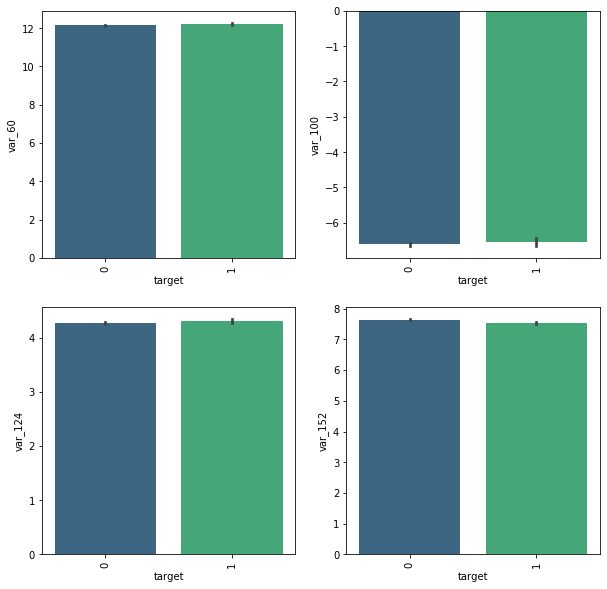

In [58]:
some_features = ['var_60', 'var_100', 'var_124', 'var_152']
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for num, feature in enumerate(some_features):
    data = train[feature].copy()
    sns.barplot(y=feature, x=target, data=train, palette="viridis", ax=axes[num//2, num%2]) 
    axes[num//2, num%2].tick_params(axis="x", rotation=90)

Распределения на выборке для обучения и для тестирования совпадают. В некоторых переменных (например, var_11, var_20, var_38, var_52, var_68, var_103, var_126 и т.п.) наблюдаются выбросы. Визуально распределение переменных близко к нормальному, но эта гипотеза требует дальнейшего исследования. Для некоторых признаков, таких как, например, var_60, var_100, var_124, var_152, визуально кажется, что доли в разрезе целевой переменной похожи. Эта гипотеза требует более тщательного изучения графиков, а также, возможно, детельного рассмотрения конкретных признаков.

**Задание 4:** Построить распределение основных статистики признаков (среднее, стандартное отклонение) в разрезе целевой переменной и распределение основных статистик обучающей и тестовой выборки, сделать выводы;

In [59]:
target1 = train.loc[train['target']==1, :].describe()
target0 = train.loc[train['target']==0, :].describe()

In [60]:
target1

target         var_0         var_1         var_2         var_3  \
count  20098.0  20098.000000  20098.000000  20098.000000  20098.000000   
mean       1.0     11.156418     -1.017613     11.156633      6.864113   
std        0.0      3.270293      4.220638      2.841075      2.070898   
min        1.0      0.452800    -14.037000      2.946200      0.374000   
25%        1.0      8.695875     -4.203475      8.961125      5.314300   
50%        1.0     11.001350     -0.992650     11.096700      6.900200   
75%        1.0     13.343700      2.001375     13.047025      8.384725   
max        1.0     19.458300      9.029800     18.294100     12.706900   

              var_4         var_5         var_6         var_7         var_8  \
count  20098.000000  20098.000000  20098.000000  20098.000000  20098.000000   
mean      11.131337     -4.336522      5.581966     16.514917      0.479432   
std        1.649266      8.140281      0.922442      3.421365      3.340028   
min        5.876200    -28.246100      2.496000      7.302400     -9.839100   
25%        9.911250    -10.615800      4.882250     13.880125     -2.107425   
50%       11.156300     -4.101950      5.601800     16.412700      0.579600   
75%       12.328450      1.619950      6.218550     19.044250      3.127825   
max       15.692500     16.423600      8.285200     27.039800      9.033000   

       ...       var_190       var_191       var_192       var_193  \
count  ...  20098.000000  20098.000000  20098.000000  20098.000000   
mean   ...      3.998064      7.864560      1.738266      3.120260   
std    ...      4.814830      3.210779      1.482537      4.067550   
min    ...    -11.906900     -2.343000     -3.317700    -11.783400   
25%    ...      0.466025      5.418550      0.669775      0.343000   
50%    ...      4.017500      7.846550      1.667500      3.176700   
75%    ...      7.407925     10.018400      2.749050      6.063825   
max    ...     16.746100     16.520500      7.647600     17.150400   

            var_194       var_195       var_196       var_197       var_198  \
count  20098.000000  20098.000000  20098.000000  20098.000000  20098.000000   
mean      17.779568     -0.021130      2.688583      8.810815     15.393283   
std        3.193153      1.485975      5.556892      0.952554      3.248123   
min       10.120700     -5.018500    -14.020400      6.119000      6.558700   
25%       15.420025     -1.103950     -1.572225      8.155250     13.232500   
50%       17.730500     -0.057350      2.831050      8.795400     15.427950   
75%       20.201800      0.986450      6.956250      9.517000     17.776425   
max       27.295300      4.088100     17.161400     11.706900     25.857100   

            var_199  
count  20098.000000  
mean      -2.532243  
std       10.435910  
min      -38.852800  
25%      -10.285050  
50%       -1.971850  
75%        5.701475  
max       24.564600  

[8 rows x 201 columns]

In [61]:
target0

target          var_0          var_1          var_2          var_3  \
count  179902.0  179902.000000  179902.000000  179902.000000  179902.000000   
mean        0.0      10.626681      -1.695770      10.665876       6.788979   
std         0.0       3.008564       4.024813       2.612961       2.040082   
min         0.0       0.408400     -15.043400       2.117100      -0.040200   
25%         0.0       8.429500      -4.790775       8.698025       5.247625   
50%         0.0      10.478600      -1.682600      10.529000       6.817000   
75%         0.0      12.693075       1.287700      12.463900       8.317875   
max         0.0      20.315000      10.376800      19.353000      13.188300   

               var_4          var_5          var_6          var_7  \
count  179902.000000  179902.000000  179902.000000  179902.000000   
mean       11.072412      -5.146736       5.389620      16.549306   
std         1.620103       7.827522       0.857983       3.417700   
min         5.074800     -32.562600       2.347300       5.349700   
25%         9.880600     -11.260950       4.756425      13.950125   
50%        11.104400      -4.917700       5.364400      16.460850   
75%        12.253100       0.844600       5.981300      19.108800   
max        16.671400      17.251600       8.447700      27.691800   

               var_8  ...        var_190        var_191        var_192  \
count  179902.000000  ...  179902.000000  179902.000000  179902.000000   
mean        0.262347  ...       3.149130       7.390800       1.949017   
std         3.331105  ...       4.522568       2.997847       1.476456   
min       -10.505500  ...     -14.093300      -2.691700      -3.814500   
25%        -2.342575  ...      -0.111850       5.130825       0.915300   
50%         0.371400  ...       3.117250       7.297000       1.928950   
75%         2.919300  ...       6.296375       9.461300       2.969800   
max        10.151300  ...      18.440900      16.716500       8.402400   

             var_193        var_194        var_195        var_196  \
count  179902.000000  179902.000000  179902.000000  179902.000000   
mean        3.355403      18.017716      -0.155601       2.260297   
std         3.982819       3.127715       1.422275       5.441118   
min       -10.845500       8.694400      -5.261000     -14.209600   
25%         0.612400      15.656700      -1.178700      -1.987375   
50%         3.417550      17.982400      -0.184200       2.359700   
75%         6.217075      20.417500       0.813000       6.513425   
max        18.281800      27.928800       4.272900      18.321500   

             var_197        var_198        var_199  
count  179902.000000  179902.000000  179902.000000  
mean        8.919032      15.924058      -3.415273  
std         0.917467       2.978539      10.434525  
min         5.960600       6.299300     -38.852800  
25%         8.262100      13.896000     -11.312025  
50%         8.897700      15.988500      -2.914000  
75%         9.601500      18.095400       4.741400  
max        12.000400      26.079100      28.500700  

[8 rows x 201 columns]

In [62]:
df_stat = pd.DataFrame(data = {'mean_0': target0.loc['mean'],
                               'mean_1': target1.loc['mean'],
                               'std_0': target0.loc['std'],
                               'std_1': target1.loc['std'],
                              })

In [63]:
pd.options.display.max_rows = 210

In [64]:
df_stat

mean_0     mean_1      std_0      std_1
target    0.000000   1.000000   0.000000   0.000000
var_0    10.626681  11.156418   3.008564   3.270293
var_1    -1.695770  -1.017613   4.024813   4.220638
var_2    10.665876  11.156633   2.612961   2.841075
var_3     6.788979   6.864113   2.040082   2.070898
var_4    11.072412  11.131337   1.620103   1.649266
var_5    -5.146736  -4.336522   7.827522   8.140281
var_6     5.389620   5.581966   0.857983   0.922442
var_7    16.549306  16.514917   3.417700   3.421365
var_8     0.262347   0.479432   3.331105   3.340028
var_9     7.584907   7.409064   1.228839   1.278709
var_10    0.398410   0.357916   5.499197   5.515060
var_11   -3.291479  -2.834888   5.955722   6.083536
var_12   14.028392  13.984464   0.187441   0.207935
var_13    8.615764   7.764618   4.603038   4.888186
var_14    7.542364   7.495020   2.248042   2.246319
var_15   14.570748  14.594414   0.410909   0.418237
var_16    9.326326   9.395369   2.551915   2.605433
var_17   -5.698669  -5.679385   6.716530   6.677587
var_18   15.129914  16.265343   7.805564   8.179688
var_19   12.408389  12.708704   7.981264   8.128723
var_20   13.326894  12.968654   5.871569   5.908411
var_21   17.418103  15.823715   8.137105   8.578688
var_22    4.247785   4.821429   2.816560   3.067136
var_23    3.024026   2.979384   0.525768   0.535207
var_24   10.548447  10.906222   3.768895   3.836304
var_25   13.666224  13.678882   0.284984   0.290182
var_26   -4.178694  -2.949112   5.847831   6.446004
var_27   -1.137611  -1.140560   1.522704   1.532760
var_28    5.539248   5.476866   0.780864   0.803272
var_29    5.049780   5.090517   2.613970   2.633303
var_30   -7.689438  -7.672537   7.967595   7.943894
var_31   10.411541  10.227496   2.159704   2.154552
var_32   -0.539278  -0.276639   2.579291   2.651428
var_33   14.838196  14.200831   4.302266   4.457194
var_34   11.443788  11.348866   0.538577   0.560916
var_35    3.779194   4.409162   5.158947   5.327264
var_36    2.227270   1.828816   3.107991   3.203155
var_37    5.863121   5.920623   2.246682   2.276233
var_38   10.640744  10.654546   4.276824   4.297554
var_39    0.668519   0.613162   4.066858   4.086348
var_40   -6.862568  -5.498624   8.215720   8.732590
var_41    9.302433   9.276805   5.932132   5.991237
var_42   11.224302  11.204937   0.695376   0.701254
var_43   11.572909  11.543503   0.308432   0.318652
var_44    9.045045   8.082197   5.835214   6.414395
var_45  -12.556114 -13.984647  21.397421  21.429591
var_46   11.321047  11.375188   2.856575   2.895122
var_47  -12.503504 -12.187384  10.581927  10.557365
var_48   14.581677  15.806031  11.363231  11.513367
var_49   16.602122  17.401971   7.828251   8.062448
var_50   12.744200  12.712219   0.689783   0.708083
var_51   13.357783  14.065603   8.148343   8.501894
var_52   -2.575063  -2.114843   4.969899   5.104844
var_53    5.992363   6.153627   0.756300   0.822540
var_54    1.181542   0.739460   8.408994   8.450879
var_55   12.713185  13.038255   5.680993   5.762603
var_56   16.670579  16.258461   3.520147   3.694106
var_57    6.276124   6.235222   0.794372   0.799936
var_58    3.212497   2.865556   4.282470   4.409752
var_59    8.934109   8.904403   0.854149   0.860148
var_60   12.146777  12.234763   4.210185   4.329399
var_61  -11.975518 -11.689180  11.616441  11.678168
var_62    0.864765   0.958362   2.021532   2.066026
var_63    0.676438   0.524536   3.107616   3.158456
var_64    6.376013   6.307787   1.484106   1.500046
var_65    0.968699   1.109933   3.785236   3.795465
var_66    5.785376   5.871587   1.118519   1.143637
var_67   11.833250  12.927617   7.330663   7.596216
var_68    5.018922   5.018636   0.007167   0.007351
var_69   -3.342466  -3.233487   3.943928   4.058563
var_70   24.339961  25.403251  11.935581  12.053624
var_71    0.666760   0.696571   0.265989   0.271486
var_72    0.657700   0.487071   3.937950   4.001472
var_73   19.627010  19.466573   7.463417   7.490732
var_74   19.424857  20.360168  14.101676  14.182555
var_75  

Средние значения и стандартные отклонения в разрезе целевой переменной для некоторых признаков очень близки. Например, выше я выдвигала гипотезу, что распределения совпадают для  var_11, var_20, var_38, var_52, var_68, var_103, var_126. Можно сказать, что стоит далее проверить эту гипотезу для var_38, var_103, var_126, т.к. среднее значение и стандартное отклонение близки. Возможно, эти признаки совсем не информативны, что требует дальнейшего изучения.

In [65]:
df_stat_train_test = pd.DataFrame(data = {'mean_train': train.describe().loc['mean'],
                               'mean_test': test.describe().loc['mean'],
                               'std_train': train.describe().loc['std'],
                               'std_test': test.describe().loc['std'],
                              })

In [66]:
df_stat_train_test

mean_train  mean_test  std_train   std_test
target     0.100490        NaN   0.300653        NaN
var_0     10.679914  10.658737   3.040051   3.036716
var_1     -1.627622  -1.624244   4.050044   4.040509
var_10     0.394340   0.371335   5.500793   5.508661
var_100   -6.600518  -6.674013   9.181683   9.181642
var_101   13.413526  13.389322   4.950537   4.953360
var_102   22.294908  22.334372   8.628179   8.630791
var_103    1.568393   1.568707   0.185020   0.185295
var_104   11.509834  11.523125   1.970520   1.974172
var_105    4.244744   4.244311   0.855698   0.857720
var_106    8.617657   8.621051   1.894899   1.890661
var_107   17.796266  17.824277   7.604723   7.598867
var_108   14.224435  14.225107   0.171091   0.171439
var_109   18.458001  18.455457   4.355031   4.368647
var_11    -3.245596  -3.268551   5.970253   5.961443
var_110    5.513238   5.497816   3.823253   3.834687
var_111    6.312603   6.313691   1.082404   1.080271
var_112    3.317843   3.311793   1.591170   1.592758
var_113    8.136542   8.145250   4.459077   4.472500
var_114    3.081191   3.086162   0.985396   0.983776
var_115    2.213717   2.199727   2.621851   2.622971
var_116    2.402570   2.392058   1.650912   1.652755
var_117   16.102233  16.039925  13.297662  13.256813
var_118   -5.305132  -5.310524   8.799268   8.767417
var_119    3.032849   3.060541   4.182796   4.175211
var_12    14.023978  14.022662   0.190059   0.190071
var_120   24.521078  24.536099  12.121016  12.105735
var_121   11.310591  11.312735   1.714416   1.708636
var_122    1.192984   1.191748   5.168479   5.145416
var_123    7.076254   7.023936   6.147345   6.140683
var_124    4.272740   4.279579   2.736821   2.728711
var_125   12.489165  12.488117   0.318100   0.317715
var_126   13.202326  13.205603   0.776056   0.779032
var_127    0.851507   0.847175   3.137684   3.150284
var_128   -1.127952  -1.132617   3.238043   3.243374
var_129   15.460314  15.435012   4.136453   4.146347
var_13     8.530232   8.540872   4.639536   4.628712
var_130   12.257151  12.256858   0.832199   0.832933
var_131    0.544674   0.547403   0.456280   0.456736
var_132    7.799676   7.801597   1.456486   1.454610
var_133    6.813270   6.814902   0.375603   0.375246
var_134   -4.826053  -4.806086   6.166126   6.170636
var_135   -4.259472  -4.309017   7.617732   7.616104
var_136   22.968602  23.019125  10.382235  10.373414
var_137   17.613651  17.647446   8.890516   8.889635
var_138    1.210792   1.243290   4.551750   4.564611
var_139    7.760193   7.765888   7.686433   7.683951
var_14     7.537606   7.532703   2.247908   2.255257
var_140    3.423636   3.411716   4.896325   4.907185
var_141    2.897596   2.873279   6.715637   6.732620
var_142   11.983489  11.971068   5.691936   5.685169
var_143   12.333698  12.335213   2.934706   2.941028
var_144    8.647632   8.644856   0.922469   0.923951
var_145    4.841328   4.860353   3.899281   3.897157
var_146   10.341178  10.362214   2.518883   2.514621
var_147   -3.300779  -3.238206   7.413301   7.444975
var_148    3.990726   3.991193   0.199192   0.198559
var_149    5.296237   5.276210  10.385133  10.374152
var_15    14.573126  14.573704   0.411711   0.411592
var_150   16.817671  16.820051   2.464157   2.463189
var_151   10.141542  10.156002   3.962426   3.971911
var_152    7.633199   7.628824   3.005373   3.015322
var_153   16.727902  16.721077   2.014200   2.013893
var_154    6.974955   6.971188   4.961678   4.972334
var_155   -2.074128  -2.043747   5.771261   5.775461
var_156   13.209272  13.208797   0.955140   0.951806
var_157   -4.813552  -4.836848   5.570272   5.576516
var_158   17.914591  17.924734   7.885579   7.867884
var_159   10.223282  10.239229   4.122912   4.133414
var_16     9.333264   9.321669   2.557421   2.544860
var_160   24.259300  24.146181  10.880263  10.876184
var_161    5.633293   5.635300   0.217938   0.217936
var_162    5.362896   5.360975   1.419612   1.426064
var_163   11.002170  11.026376   5.262056   5.268894
var_164   -2.871906  -2.857328   5

Существенных отличий для основных статистик на трейне и тесте не наблюдается

**Задание 5:** Построить распределение коэффициентов корреляции между признаками. Есть ли зависимость между признаками (будем считать, что связь между признаками отсутствует, если коэффициент корреляции < 0.2)?

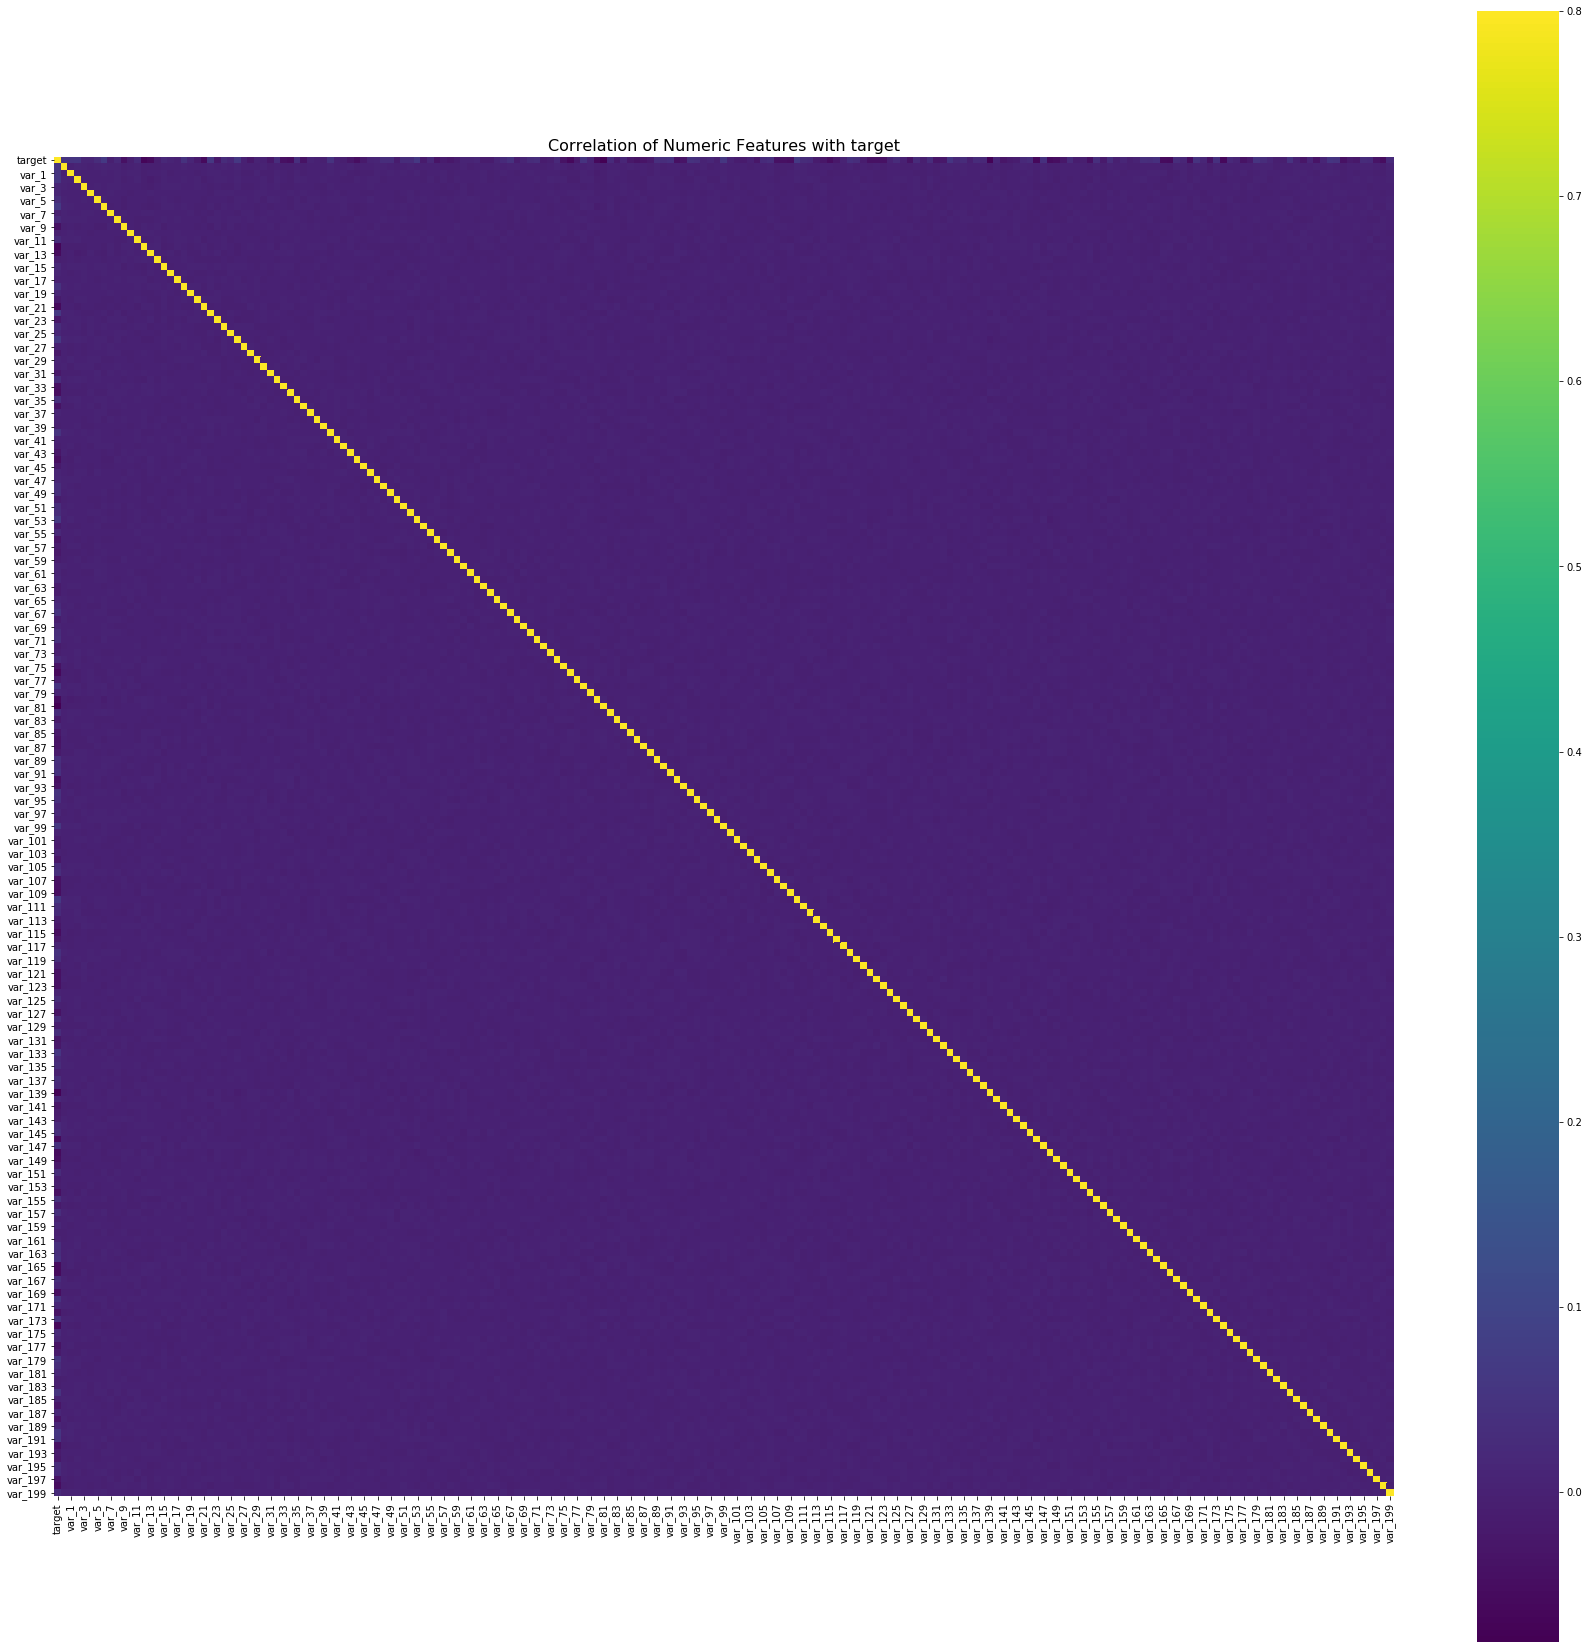

In [67]:
correlation = numerical_features.corr()
fig, axes = plt.subplots(figsize = (30,30))
plt.title("Correlation of Numeric Features with target", y=1, size=16)
sns.heatmap(correlation, square=True, vmax=0.8, cmap="viridis")

По Correlation Heat Map данные между собой не скоррелированы, но, как мне кажется, нужно проверить корреляцию с целевой переменной некоторых признаков, которые (при увеличении картинки) имеют более светлую окраску, близкую к 0,2 (например, var_6, var_40, var_78 и др.)

In [68]:
corr_with_target = correlation["target"].sort_values(ascending = False)
corr_with_target.head(10)

target     1.000000
var_6      0.066731
var_110    0.064275
var_53     0.063399
var_26     0.062422
var_22     0.060558
var_99     0.058367
var_190    0.055973
var_2      0.055870
var_133    0.054548
Name: target, dtype: float64

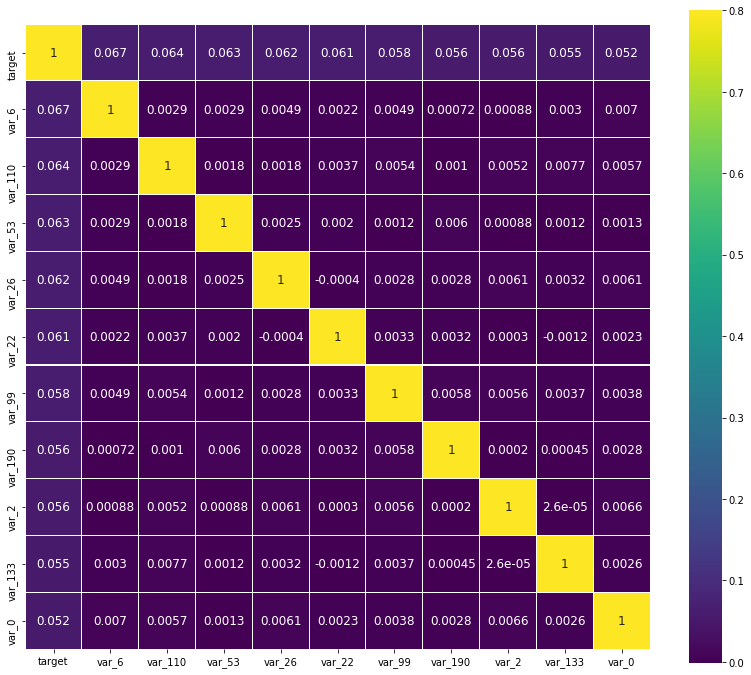

In [69]:
k = 11
cols = correlation.nlargest(k, "target")["target"].index
cm = np.corrcoef(train[cols].values.T)
fig, axes = plt.subplots(figsize = (14, 12))

sns.heatmap(
    cm,
    vmax=.8,
    linewidths=0.01,
    cmap="viridis",
    square=True,
    annot=True,
    linecolor="white",
    xticklabels=cols.values,
    annot_kws = {"size": 12},
    yticklabels=cols.values
)

C:\Users\gromo\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


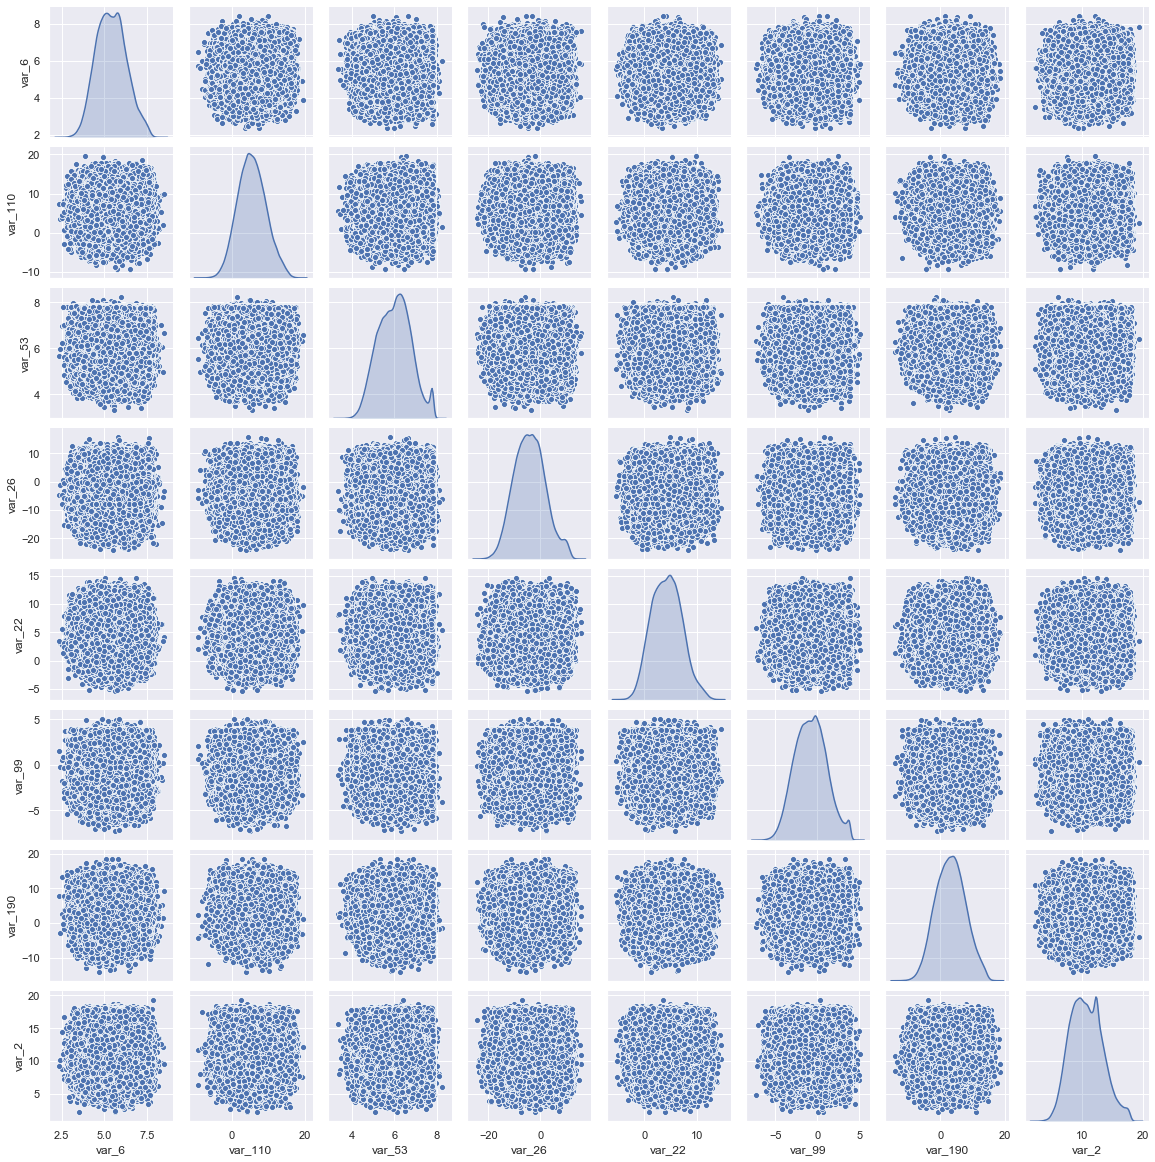

In [71]:
sns.set()
columns = [
    "var_6",
    "var_110",
    "var_53",
    "var_26",
    "var_22",
    "var_99",
    "var_190",
    "var_2"
]

sns.pairplot(train[columns], size=2, kind="scatter", diag_kind="kde")
plt.show()

Данные не скоррелированы с целевой переменной и между собой

**Задание 6:** Выявить 10 признаков, которые обладают наибольшей нелинейной связью с целевой переменной.

In [38]:
%%time
parameters = {"max_depth": 6, "n_estimators": 25, "random_state": 27, "n_jobs": 2}

forest = RandomForestRegressor(**parameters)
forest.fit(numerical_features.fillna(-9999).drop("target", axis=1), target)

Wall time: 3min 19s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=25, n_jobs=2, oob_score=False,
                      random_state=27, verbose=0, warm_start=False)

Text(0.5, 1.0, 'What are the top important features to start with?')

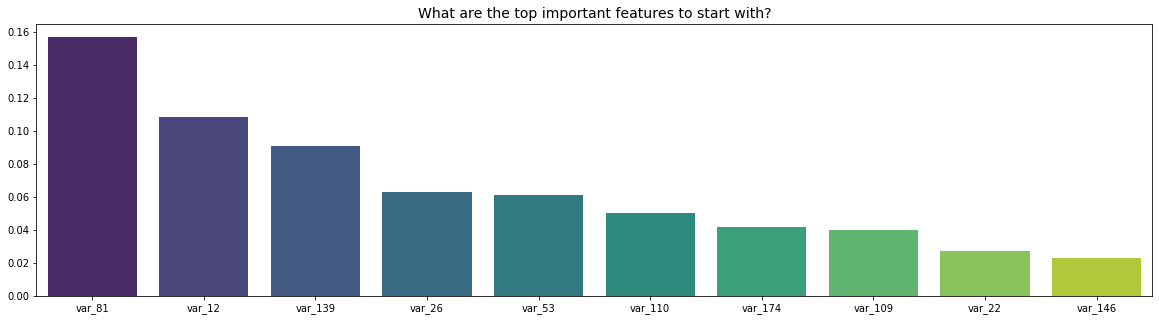

In [39]:
n_top = 10
importances = forest.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = numerical_features.drop("target", axis=1).columns

plt.figure(figsize=(20, 5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)

Значимой нелинейной связи не наблюдается

**Задание 7:** Провести анализ идентичности распределения признаков на обучающей и тестовой выборках, сделать выводы.

In [40]:
features_to_score = numerical_features.drop(["target"], axis=1).columns.tolist()

X_adv = pd.concat([
    train[features_to_score], test[features_to_score]
])
y_adv = np.hstack(
    (np.ones(train.shape[0]), np.zeros(test.shape[0])))

X_adv = X_adv.reset_index(drop=True)

In [41]:
%%time
parameters = {"max_depth": 4, "n_estimators": 50, "random_state": 27, "n_jobs": 2}
model = xgb.XGBClassifier(**parameters)

cv = cross_val_score(
    estimator=model,
    X=X_adv, y=y_adv,
    scoring="roc_auc",
    cv=KFold(n_splits=3, shuffle=True, random_state=27)
)

print(f"CV-score: {round(np.mean(cv), 4)}")

CV-score: 0.5116
Wall time: 4min 22s


Text(0.5, 1.0, 'Top Importance Features for Adversarial Validation (train vs test)')

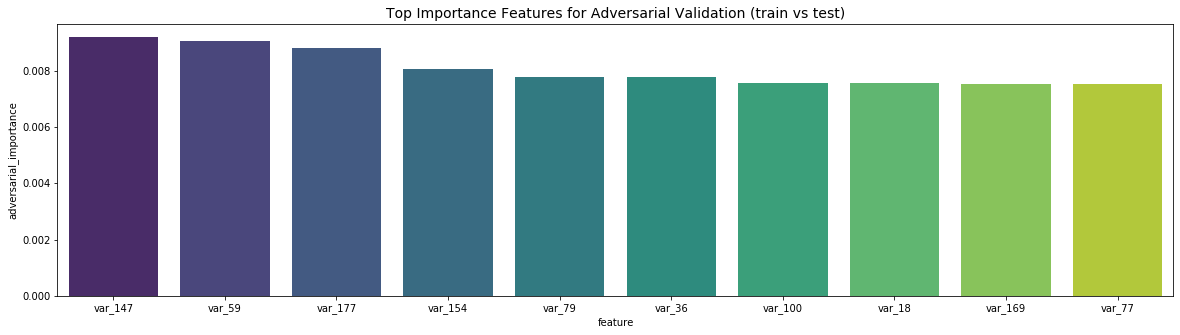

In [42]:
model.fit(X_adv, y_adv)

importance = pd.DataFrame({
    "feature": X_adv.columns,
    "adversarial_importance": model.feature_importances_
})
importance = importance.sort_values(by="adversarial_importance", ascending=False)
importance = importance.head(n=10)

plt.figure(figsize=(20, 5))
sns.barplot(x=importance["feature"], y=importance["adversarial_importance"], palette="viridis")
plt.title("Top Importance Features for Adversarial Validation (train vs test)", size=14)

CV-score: 0.5116 - классификатор близок к случайному гаданию, он не отличает трейн от теста, что показывает идентичность распределения признаков на обучающей и тестовой выборках. В "Top Importance Features for Adversarial Validation" выведены 10 признаков, которые максимально отличаются в трейне и тесте. При дальнейшем исследовании данных можно принять решение об удалении этих данных.